In [ ]:
from spikingjelly.activation_based.neuron import ParametricLIFNode, LIFNode, BaseNode, IFNode
from spikingjelly.activation_based.layer import Linear
from jaxtyping import Float, Int64
from torch import Tensor

import torch
import matplotlib.pyplot as plt
import numpy as np
import spikingjelly.activation_based as snn
from spikingjelly.activation_based import surrogate, neuron, functional
from typing import Callable, Any, overload
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from utils.datasets import generate_lp_dataset, encode_temporal

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)
rng = torch.manual_seed(42)

In [3]:
import torch

class StochasticRound(torch.autograd.Function):
    """
    확률적 라운딩 (Stochastic Rounding)을 위한 Straight-Through Estimator (STE)
    
    - Forward Pass:  입력 x를 floor(x) 또는 ceil(x)로 확률적으로 붕괴시킴.
                     P(ceil(x)) = x - floor(x)
                     P(floor(x)) = 1 - (x - floor(x))
    - Backward Pass: 그래디언트를 1로 그대로 통과시킴 (Identity).
    """
    
    @staticmethod
    def forward(ctx, x: torch.Tensor) -> torch.Tensor:
        """
        Forward Pass: 확률적 라운딩 수행
        """
        # 1. floor 값과 ceil 확률(p) 계산
        #    (예: x=2.7 -> x_floor=2.0, p=0.7)
        x_floor = torch.floor(x)
        p = x - x_floor  # ceil(x)가 될 확률
        
        # 2. 확률적 붕괴
        # r < p (이 이벤트는 p의 확률로 발생) 이면 ceil(x) = x_floor + 1
        # 아니면 (1-p의 확률로 발생) floor(x)
        rounded_x = torch.where(torch.bernoulli(p).bool(), x_floor + 1.0, x_floor)
        
        return rounded_x.long()

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        """
        Backward Pass (STE):
        그래디언트를 그대로 통과시킴
        """
        # (d_loss / d_rounded_x) * (d_rounded_x / d_x)
        # STE는 d_rounded_x / d_x 를 1로 가정함
        return grad_output

In [4]:
class TransposeLayer(torch.nn.Module):
    dims: tuple[int, int]

    def __init__(self, dims: tuple[int, int]) -> None:
        super().__init__()
        self.dims = dims

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return input.transpose(*self.dims)

class SynapticDelayConvolution(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input: torch.Tensor, delay: torch.nn.Parameter) -> torch.Tensor:
        """Apply synaptic delay to the one-hot coded input tensor.
        
        :param ctx: 설명
        :param input: The input tensor to apply delay to. shape: (T, N, C, D_out, D_in)
        :type input: torch.Tensor
        :param delay: The delay tensor to apply. shape: (D_out, D_in)
        :type delay: torch.nn.Parameter
        :return: The output tensor after applying synaptic delay. shape: (T, N, C, D_out, D_in)
        :rtype: Tensor
        """
        output = input.clone()
        T, N, C, D_out, D_in = output.shape
        rounded_delay:Int64[Tensor, "N C D_out D_in"] = StochasticRound.apply(delay[None,None,...].repeat(N, C, 1, 1)) # type: ignore
        rounded_delay = rounded_delay.clamp(max= (T - 1) - output.argmax(dim=0))
            # (T-1) is the last timestep, argmax to indicate spike time
        for n in range(N):
            for c in range(C):
                for d_out in range(D_out):
                    for d_in in range(D_in):
                        output[:, n, c, d_out, d_in] = output[:, n, c, d_out, d_in].roll(int(rounded_delay[n, c, d_out, d_in]), dims=0)

        # ctx.save_for_backward(output, rounded_delay)

        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        """
        Backward Pass (STE): 'delay'에 대한 가짜 그래디언트를 계산하여 반환
        
        grad_output: Loss에 대한 shifted_vec의 그래디언트 (d_loss / d_shifted_vec)
        """
        
        #TODO: Gradient of clamped delay?
        # output, delay = ctx.saved_tensors
        # T, N, C, D_in, D_out = output.shape
        
        # 'delay'에 대한 그래디언트만 계산 (vec의 그래디언트는 None)
        grad_delay = None
        
        # 'delay'가 그래디언트를 요구할 때만 (needs_input_grad[1]) 계산
        if ctx.needs_input_grad[1]:
            grad_delay = grad_output
        
        # vec의 그래디언트(None), d의 그래디언트 순서로 반환
        return None, grad_delay

class SDCLinear(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.log_delay = torch.nn.Parameter(torch.randn(out_features, in_features))
        self.log_weight = torch.nn.Parameter(torch.randn(out_features, in_features))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        T, N, C, D_in = input.shape
        output = input.unsqueeze(-2).repeat([1] * (len(input.shape) - 1) + [self.out_features, 1]) # ..., d_in -> ..., d_out, d_in
        output = SynapticDelayConvolution.apply(output, self.log_delay.exp() * T); assert isinstance(output, torch.Tensor)
        output.mul_(self.log_weight.exp())
        output = output.sum(dim=-1)

        return output


In [ ]:
class CCN(torch.nn.Module):
    def __init__(self,
                 vector_dim:int,
                 cc_acc:int,
                 feature_dims:list[int]):
        """
        Cross-correlation network initialization.
        
        :param self: 설명
        :param input_dim: ...
        :param n_acc: 설명
        """
        super(CCN, self).__init__()
        self.vector_dim = vector_dim
        self.cc_acc = cc_acc
        self.feature_dims = feature_dims
        
        self.model = torch.nn.Sequential(
            torch.nn.Unflatten(2, (2, self.vector_dim)), # T,N,2D -> T,N,2,D
            TransposeLayer((2,3)), # T,N,2,D -> T,N,D,2
            SDCLinear(2, self.cc_acc), # T,N,D,2 -> T,N,D,cc_acc
            IFNode(v_reset=0., surrogate_function=surrogate.ATan(), step_mode="m", backend="cupy"), # T,N,D,cc_acc -> T,N,D,cc_acc
            torch.nn.Flatten(start_dim=2) # T,N,D,cc_acc -> T,N,D*cc_acc
            
            # For ANN Simulation
            # TransposeLayer((0,1)),
            # torch.nn.Flatten(start_dim=1),
            # torch.nn.Linear(2 * self.vector_dim * 20, self.cc_acc * self.vector_dim),
            # torch.nn.ReLU()
        )
        
        feature_dims = [self.cc_acc * self.vector_dim] + self.feature_dims
        for in_dim, out_dim in zip(feature_dims[:-1], feature_dims[1:]):
            self.model.append(torch.nn.Linear(in_dim, out_dim))
            # self.model.append(LIFNode(v_reset=None, surrogate_function=surrogate.ATan()))
        

    def forward(self, x:Float[Tensor, "T N 2D"], return_rate:bool=True, reset:bool=True):
        """
        Compute the correlation between two input tensors.
        
        :param self: 설명
        :param x: 설명
        :type x: torch.Tensor
        """
        if reset:
            for layer in self.model:
                if isinstance(layer, BaseNode):
                    layer.reset()

        for i, layer in enumerate(self.model):
            x = layer(x)
            # print(i, x)
    
        if return_rate:
            x = x.sum(dim=0)
        return x


In [6]:
NUM_SAMPLES = 1000  # 총 1000 개의 샘플 생성
VECTOR_DIM = 3      # 각 벡터는 3차원
MAX_VAL = 10.0
TIME_STEPS = 20     # SNN을 20 타임스텝 동안 실행
BATCH_SIZE = 32

model = CCN(vector_dim = VECTOR_DIM, cc_acc=10, feature_dims=[1]).to(device)
model

CCN(
  (model): Sequential(
    (0): Unflatten(dim=2, unflattened_size=(2, 3))
    (1): TransposeLayer()
    (2): SDCLinear()
    (3): IFNode(
      v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=m, backend=torch
      (surrogate_function): ATan(alpha=2.0, spiking=True)
    )
    (4): Flatten(start_dim=2, end_dim=-1)
    (5): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [7]:
X_data, y_data = generate_lp_dataset(NUM_SAMPLES, VECTOR_DIM, p=2.0, max_val=MAX_VAL)
X_data = torch.FloatTensor(encode_temporal(X_data, TIME_STEPS)) # TN(2D)
y_data = torch.FloatTensor(y_data) / y_data.max() # ND
dataset = torch.utils.data.TensorDataset(X_data.transpose(1, 0), y_data)  # TN(2D) -> NT(2D)

train_test_split:Callable[[np.ndarray, float, int], tuple[np.ndarray, np.ndarray]] = train_test_split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)


In [8]:
X_data, y_data = generate_lp_dataset(NUM_SAMPLES, VECTOR_DIM, p=2.0, max_val=MAX_VAL)
X_data = torch.FloatTensor(encode_temporal(X_data, TIME_STEPS)) # TN(2D)
y_data = torch.FloatTensor(y_data) / y_data.max() # ND
dataset = torch.utils.data.TensorDataset(X_data.transpose(1, 0), y_data)  # TN(2D) -> NT(2D)

train_test_split:Callable[[np.ndarray, float, int], tuple[np.ndarray, np.ndarray]] = train_test_split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=False
    )
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
loss = torch.tensor(float("inf"))

pbar = tqdm(range(40))
pred_hist, target_hist, diff_hist = [], [], []
for epoch in pbar:
    model.train()
    for batch in tqdm(train_loader, leave=False):
        inputs:Float[Tensor, "N T 2D"]; targets:Float[Tensor, "N D"]
        inputs, targets = batch
        inputs = inputs.to(device); targets = targets.to(device)
        # 모델 학습 코드 추가
        out:Float[Tensor, "N D"] = model(inputs.transpose(1, 0)) # NT(2D)->TND->model->ND
        loss = criterion(out, targets)
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        pbar.set_postfix({"loss": loss.item()})
    scheduler.step()
    
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_loader, leave=False):
            inputs, targets = batch
            inputs = inputs.to(device); targets = targets.to(device)
            # 모델 학습 코드 추가
            out = model(inputs.transpose(1, 0)) # NT(2D)->TN(2D)->model->N
            
            loss = criterion(out, targets)
            pred_hist.extend(out.squeeze().tolist())
            target_hist.extend(targets.squeeze().tolist())
            diff_hist.extend((out - targets).squeeze().tolist())
            pbar.set_postfix({"loss": loss.item(), "pred": pred_hist[-1], "target": target_hist[-1]})

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

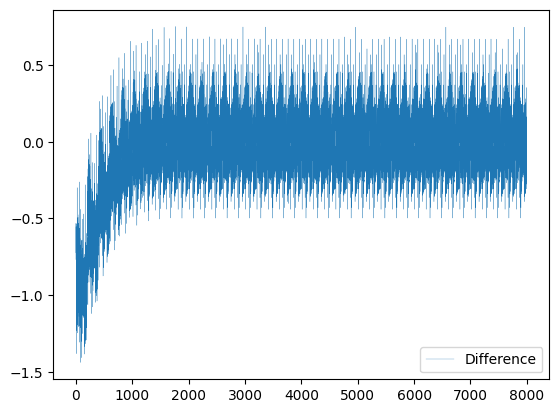

In [9]:
plt.plot(diff_hist, linewidth=0.2, label="Difference")
plt.legend()

In [10]:
sample = dataset[0:50]
inputs, targets = sample
inputs = inputs.to(device); targets = targets.to(device)
out = model(inputs.transpose(1, 0))

In [11]:
torch.hstack((out, targets))

tensor([[0.6053, 0.0694],
        [0.3184, 0.5682],
        [0.6053, 0.3141],
        [0.5899, 0.6284],
        [0.4953, 0.6385],
        [0.3665, 0.5206],
        [0.5257, 0.2265],
        [0.6053, 0.2754],
        [0.6033, 0.3119],
        [0.4135, 0.4392],
        [0.6053, 0.2548],
        [0.3665, 0.4914],
        [0.3820, 0.2164],
        [0.6534, 0.3233],
        [0.3665, 0.5543],
        [0.6053, 0.5067],
        [0.3990, 0.7779],
        [0.3665, 0.3113],
        [0.2543, 0.3324],
        [0.6053, 0.5977],
        [0.3354, 1.0000],
        [0.3044, 0.4614],
        [0.3685, 0.7578],
        [0.5108, 0.6042],
        [0.4776, 0.4941],
        [0.5584, 0.4444],
        [0.7176, 0.4254],
        [0.4765, 0.5473],
        [0.4631, 0.6906],
        [0.6359, 0.3781],
        [0.5278, 0.5716],
        [0.1767, 0.6467],
        [0.4461, 0.6724],
        [0.3184, 0.6182],
        [0.4942, 0.4498],
        [0.3830, 0.5521],
        [0.2543, 0.3875],
        [0.4631, 0.7192],
        [0.5